In [1]:
import os
import configparser
import logging
import numpy as np
import torch
import cv2
import pandas as pd
from PIL import Image
from meegnet_functions import load_single_subject
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from meegnet.parsing import parser, save_config
from meegnet.dataloaders import EpochedDataset
from meegnet.network import Model
from mne.viz import plot_topomap
from sklearn.decomposition import PCA

info = np.load(f"../camcan_info_mag.npy", allow_pickle=True).tolist()

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
n_channels = "ALL"
input_size = (3, 102, 400)
sfreq = 500

n_outputs = 2 # using auditory vs visual stimulus classification -> 2 classes
n_subjects = 1000
n_samples = None # We will use all trials for each subject

# Setting up paths
classif = "eventclf" # also used for naming files and for model name
save_path = f"/home/arthur/nvme/{classif}"
model_path = save_path

# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 42 

# net option can be "meegnet", "eegnet" etc, see documentation
# net_option = "meegnet" 
net_option = "eegnet" 

# name of the model
name = f"{classif}_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
# my_model.from_pretrained()
model_path = os.path.join(save_path, name + ".pt")
my_model.load(model_path)
print("Model Loaded.")

fig_path = os.path.join(save_path, "figures", name)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

Model Loaded.


In [3]:
csv_file = os.path.join(save_path, f"participants_info.csv")
dataframe = (
    pd.read_csv(csv_file, index_col=0)
    .sample(frac=1, random_state=seed)
    .reset_index(drop=True)[: n_subjects]
)
subj_list = dataframe["sub"]
np.random.seed(seed)

In [4]:
print(my_model.net)

EEGNet(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 16, kernel_size=(1, 64), stride=(1, 1), padding=(1, 32), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): DepthwiseConv2d(
      (depthwise): Conv2d(16, 32, kernel_size=(102, 1), stride=(1, 1), groups=16, bias=False)
    )
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.5, inplace=False)
    (7): SeparableConv2d(
      (depthwise): DepthwiseConv2d(
        (depthwise): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(1, 8), groups=32, bias=False)
      )
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 8), bias=False)
    )
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): AvgPool2d(kernel_size=(1, 8),

In [5]:
for i, layer in enumerate(my_model.net.feature_extraction):
    print(i, layer)

0 Conv2d(3, 16, kernel_size=(1, 64), stride=(1, 1), padding=(1, 32), bias=False)
1 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 DepthwiseConv2d(
  (depthwise): Conv2d(16, 32, kernel_size=(102, 1), stride=(1, 1), groups=16, bias=False)
)
3 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
4 ELU(alpha=1.0)
5 AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
6 Dropout(p=0.5, inplace=False)
7 SeparableConv2d(
  (depthwise): DepthwiseConv2d(
    (depthwise): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(1, 8), groups=32, bias=False)
  )
  (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 8), bias=False)
)
8 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
9 ELU(alpha=1.0)
10 AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
11 Dropout(p=0.5, inplace=False)
12 Flatten()


In [6]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam import GuidedBackpropReLUModel
import torch.nn.functional as F

In [7]:
all_cams = [[],[]]
net = my_model.net
layer = net.feature_extraction[7]
target_layers = [layer]

for sub in subj_list:
    dataset = EpochedDataset(
        sfreq=sfreq, # sampling frequency of 500Hz
        n_subjects=n_subjects,
        n_samples=n_samples,
        sensortype='ALL', # we use MAG GRAD GRAD here
        lso=True,
        random_state=seed,
    )
    dataset.load(save_path, one_sub=sub)
    if len(dataset) == 0:
        continue
    labels = dataset.target_labels

    for i, label in enumerate(labels):
        gradcam = GradCAM(model=net, target_layers=target_layers)
        input_tensor = dataset.data[dataset.targets == i]

        # Check model confidence
        outputs = net(input_tensor.to('cuda'))  # Forward pass
        probabilities = F.softmax(outputs, dim=1)
        confidences = probabilities[:, i].cpu()  # Confidence for class `i`
        high_conf_indices = confidences > 0.9  # Filter high-confidence predictions
            
        if high_conf_indices.sum() > 0:  # Only proceed if there are high-confidence predictions
            high_conf_input_tensor = input_tensor[high_conf_indices]

            # Compute Grad-CAM only for high-confidence samples
            grayscale_cam = gradcam(input_tensor=high_conf_input_tensor,
                                    targets=[ClassifierOutputTarget(i)])
            valid_cams = [cam for cam in grayscale_cam if not np.isnan(cam).any() and cam.max() > 0]
            
            if len(valid_cams) > 0:
                average_cam = np.mean(valid_cams, axis=0)
                all_cams[i].append(average_cam)
                
all_cams = [np.array(label_cams) for label_cams in all_cams]

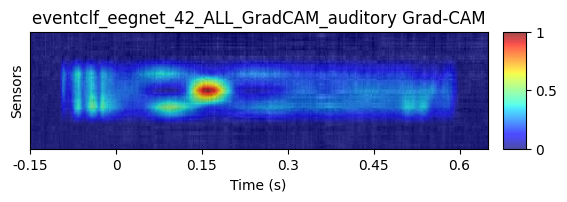

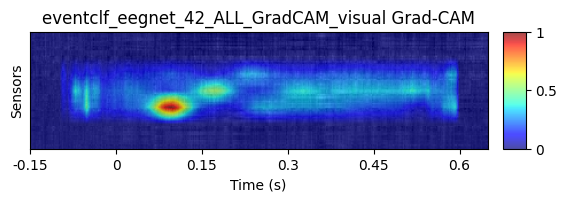

In [8]:
for i, label in enumerate(labels):
    grayscale_cam = all_cams[i].mean(axis=0) # subject 0
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())
    img = np.moveaxis(np.array(input_tensor[0]), 0, 2)
    img = np.array([img[:,:,0]]*3)
    img = np.moveaxis(img, 0, 2)
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
    
    # gb_model = GuidedBackpropReLUModel(model=net, device='cuda')
    # gb = gb_model(input_tensor)
    
    # cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    # cam_gb = deprocess_image(cam_mask * gb)
    # gb = deprocess_image(gb)
    
    method = "GradCAM"
    cam_output_path = os.path.join(fig_path, f'{name}_{method}_{label}_cam.png')
    # gb_output_path = f'{method}_gb.jpg'
    # cam_gb_output_path = f'{method}_cam_gb.jpg'
    
    if os.path.exists(cam_output_path):
        os.remove(cam_output_path)
    cv2.imwrite(cam_output_path, cam_image)
    # cv2.imwrite(gb_output_path, gb)
    # cv2.imwrite(cam_gb_output_path, cam_gb)

    # Plot with colorbar and axis labels
    fig, ax = plt.subplots()
    ax.imshow(img, aspect='auto')  # Show the original image
    im = ax.imshow(grayscale_cam, cmap='jet', alpha=0.7)  # Overlay heatmap
    ax.set_title(f'{name}_{method}_{label} Grad-CAM')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Sensors")
    ax.set_xticks([0, 75, 150, 225, 300, 375])  # Set x-axis ticks
    ax.set_xticklabels([-0.15, 0, 0.15, 0.3, 0.45, 0.6])
    ax.set_yticks([])  # Remove y-axis ticks

    # Add colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels([0, 0.5, 1])

    plt.savefig(os.path.join(fig_path, f'{name}_{method}_{label} Grad-CAM_with_colorbar.png'))
    plt.show()

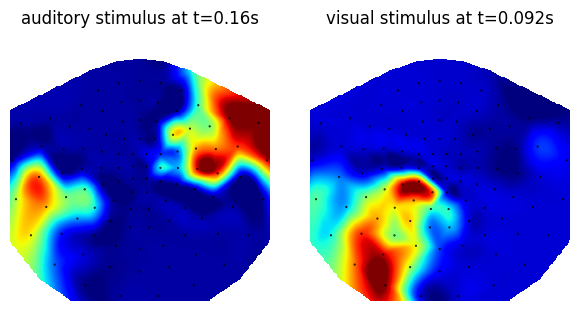

In [9]:
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=2, layout="constrained")
plt.title("PCA of Gradcam mask")

for i, label in enumerate(labels): 
    grayscale_cam = all_cams[i].mean(axis=0) # subject 0
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())
    best_timing = grayscale_cam.max(axis=0).argmax()
    
    pca = PCA(10)
    # pca.fit(cams.mean(axis=0).T)
    pca.fit(all_cams[i][:,:,best_timing])
    component = pca.components_[0]
    component = (component - component.min()) / (component.max() - component.min())

    axes[i].set_title(f"{label} stimulus at t={(best_timing - 75)/sfreq}s")
    im, _ = plot_topomap(
        component,
        info,
        axes=axes[i],
        res=300,
        show=False,
        outlines=None,
        contours=0,
        cmap='jet'
    )
    
out_path = os.path.join(fig_path, f"{method}_mask_PCA.png")
# plt.tight_layout()
plt.savefig(out_path, dpi=300)
plt.show()

55.568035
71.84608


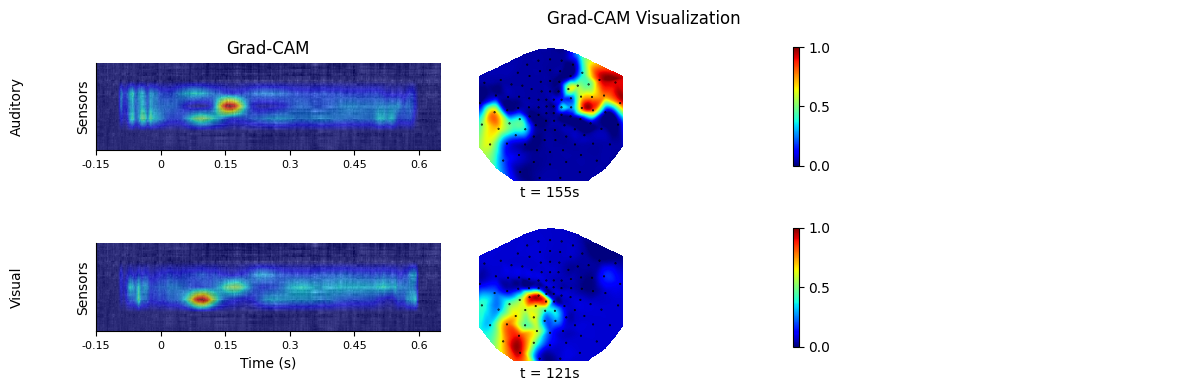

In [10]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import copy
from mne.viz import plot_topomap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

outlines = None
title = "Grad-CAM Visualization"
labels = ["Auditory", "Visual"]

block_size = 5
tick_ratio = 1000 / 500
n_blocs = 1  # Only one "bloc" for Grad-CAMs
n_lines = len(all_cams)  # Number of lines for the pyplot figure
n_cols = n_blocs * block_size + 1  # Number of columns for the pyplot figure

grid = GridSpec(n_lines, n_cols)
fig = plt.figure(figsize=(n_cols * 2, n_lines * 2))
plt.title(title)
plt.axis("off")
axes = []

for i, (label, cams) in enumerate(zip(labels, all_cams)):
    grayscale_cam = all_cams[i].mean(axis=0)
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())
    best_timing = grayscale_cam.max(axis=0).argmax()
    
    # PCA for topomap
    pca = PCA(10)
    pca.fit(all_cams[i][:, :, best_timing])  # Compute PCA on all cams at the best timing
    components = pca.components_
    
    for j in range(0, n_blocs * block_size, block_size):
        idx = j // block_size
        length = grayscale_cam.shape[1]
        grads = grayscale_cam[:, :length]  # No padding for Grad-CAMs

        axes.append(fig.add_subplot(grid[i, j : j + 2]))
        img = np.moveaxis(np.array(input_tensor[0]), 0, 2)
        img = np.array([img[:, :, 0]] * 3)
        img = np.moveaxis(img, 0, 2)
        plt.imshow(img, 
                   # interpolation=None,
                   aspect=1,
                  )
        im = plt.imshow(grayscale_cam, cmap='jet', alpha=0.6, aspect=1)  # Overlay heatmap
        axes[-1].spines["top"].set_visible(False)
        axes[-1].spines["right"].set_visible(False)
        axes[-1].yaxis.tick_right()

        x_ticks = [0, int(length / 2), length]
        plt.xticks([0, 75, 150, 225, 300, 375], fontsize=8)
        axes[-1].set_xticklabels([-0.15, 0, 0.15, 0.3, 0.45, 0.6])
        axes[-1].set_yticks([])

        if j == 0:
            axes[-1].text(-100, 50, label, ha="left", va="center", rotation="vertical")
            # axes[-1].text(-100, 50, label, ha="left", va="center")
        if idx == n_blocs - 1:
            axes[-1].yaxis.set_label_position("left")
        if i == 0:
            plt.title("Grad-CAM")
        if i == 1:
            plt.xlabel("Time (s)")
        if idx == 0:
            axes[-1].set_ylabel("Sensors")

        # Add Topomaps
        # for comp in range(3):
        for comp in range(1):
            axes.append(fig.add_subplot(grid[i, j + 2 + comp]))
            topo_data = (components[comp] - components[comp].min()) / (components[comp].max() - components[comp].min())  # Normalize
            im_topo, _ = plot_topomap(
                topo_data,
                info,
                axes=axes[-1],
                res=300,
                show=False,
                contours=0,
                cmap='jet',
                outlines=None,
                vlim = (-0.005, 1.1)
            )
            var = 100*pca.explained_variance_ratio_[comp]
            print(var)
            # axes[-1].set_xlabel(f"t = {best_timing}s; var = {var:.2f}%")
            axes[-1].set_xlabel(f"t = {best_timing}s")

        
        if idx == n_blocs - 1:
            axes.append(fig.add_subplot(grid[i, n_blocs * 3 + comp ]))

            # Fix the alpha issue using ScalarMappable for the colorbar
            norm = Normalize(vmin=0, vmax=1)  # Use the same vmin and vmax as the image
            sm = ScalarMappable(cmap='jet', norm=norm)  # Create a ScalarMappable for the colorbar
            sm.set_array([])  # Required to create a colorbar from ScalarMappable
            
            fig.colorbar(
                sm,
                ax=axes[-1],  # Attach to the correct axis
                location="right",
                ticks=(0, 0.5, 1),  # Use appropriate ticks
                shrink=0.8,  # Adjust size as needed
            )
            axes[-1].axis("off")

out_path = "all_gradcams_visualization.png"
plt.tight_layout()
plt.savefig(os.path.join(fig_path, out_path), dpi=300)
